## data processing using Apache Spark and H2O.ai 

In [1]:
from pyspark.sql import SparkSession

In [3]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,4 hours 56 mins
H2O_cluster_timezone:,Europe/Warsaw
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_nurma_o3ma4x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.883 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Data Preparation

In [4]:
spark = SparkSession.builder \
    .appName("Spark H2O Integration") \
    .getOrCreate()

In [5]:
# Load the heart dataset into Spark DataFrame
spark_df = spark.read.csv("heart.csv", header=True, inferSchema=True)

In [6]:
spark_df.show(7)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 7 rows



In [7]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_df.toPandas()
pandas_df.head(7)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0


In [8]:
# Convert Pandas DataFrame to H2O DataFrame
h2o_df = h2o.H2OFrame(pandas_df)
h2o_df.show()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
52,1,0,125,212,0,1,168,0,1,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1,1,0,2,1
58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


### Model Training

In [9]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, target_data, test_size=0.2, random_state=42)
train_h2o, test_h2o = h2o_df.split_frame(ratios=[0.8], seed=1234)

In [10]:
# Import necessary libraries
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [12]:
# Define the classification algorithm (Gradient Boosting Machine in this case)
gbm = H2OGradientBoostingEstimator(seed=1234)

# Define hyperparameters grid for tuning
hyper_params = {
    'ntrees': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learn_rate': [0.01, 0.1, 0.2]
}

In [13]:
# Perform grid search with cross-validation to find the best hyperparameters from traingning data
print("Grid Search Results:")
grid_search = H2OGridSearch(model=gbm, hyper_params=hyper_params)
grid_search.train(x=pandas_df.columns[:-1], y=pandas_df.columns[-1], training_frame=train_h2o)

Grid Search Results:
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,learn_rate,max_depth,ntrees,model_ids,residual_deviance
,0.2,7.0,150.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_27,0.0000745
,0.2,7.0,100.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_18,0.0002374
,0.2,5.0,150.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_24,0.0003997
,0.1,7.0,150.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_26,0.0005617
,0.1,7.0,100.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_17,0.0013732
,0.2,5.0,100.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_15,0.0013806
,0.2,7.0,50.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_9,0.0014592
,0.1,5.0,150.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_23,0.0030318
,0.1,7.0,50.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_8,0.0045784
,0.2,5.0,50.0,Grid_GBM_py_2_sid_9fa7_model_python_1712864466422_8_model_6,0.0052285


In [14]:
# Get the best model from the grid search
best_model = grid_search.get_grid()[0]

In [16]:
print(best_model.summary())

print(best_model.model_performance(test_data=test_h2o))

Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    150                150                         50349                  7            7            7             10            49            21.9733
ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.00040814970206094785
RMSE: 0.020202715215063245
MAE: 0.010068608250005301
RMSLE: 0.01281587495328416
Mean Residual Deviance: 0.00040814970206094785


In [17]:
import warnings
warnings.simplefilter("ignore", RuntimeWarning)
# Train the model on the training data and check model performance
best_model.train(x=h2o_df.columns[:-1], y=h2o_df.columns[-1], training_frame=train_h2o)

print(best_model._model_json['output']['model_summary'])

print(best_model._model_json['output']['training_metrics'])

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          15919                  5            5            5             10            30            20.64
ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.014094423772357293
RMSE: 0.11871993839434593
MAE: 0.0752726310388764
RMSLE: 0.0886621490665124
Mean Residual Deviance: 0.014094423772357293


In [18]:
#check model performance on test data
test_performance = best_model.model_performance(test_data=test_h2o)
print("\nTest Data Performance:")
print(test_performance)


Test Data Performance:
ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.027682757194495887
RMSE: 0.1663813607183686
MAE: 0.09791170017583235
RMSLE: 0.12134288983168533
Mean Residual Deviance: 0.027682757194495887


### Model Evaluation

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from h2o.utils.threading import local_context

In [21]:
# Evaluate the model performance on the testing set
test_predictions = best_model.predict(test_h2o).as_data_frame()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [22]:
# Get actual target values from the test set H2O DataFrame
actual_values = test_h2o.as_data_frame()['target'].values

In [24]:
threshold = 0.5

test_predictions_binary = (test_predictions['predict'] > threshold).astype(int)

In [25]:
print("\nClassification Report:")
print(classification_report(actual_values, test_predictions_binary))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       114
           1       0.97      0.96      0.96        92

    accuracy                           0.97       206
   macro avg       0.97      0.97      0.97       206
weighted avg       0.97      0.97      0.97       206



In [26]:
# Plot ROC curve and calculate AUC if applicable
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_h2o.as_data_frame()['target'].values, test_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

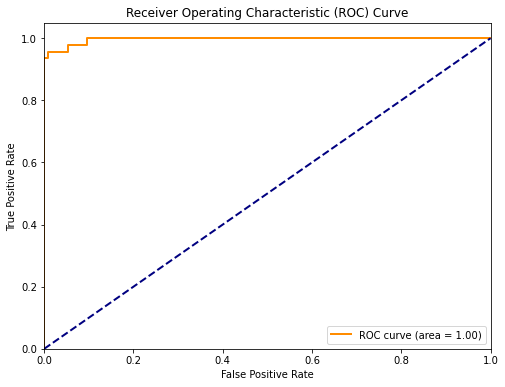

AUC: 0.9965675057208238


In [27]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print("AUC:", roc_auc)

In [28]:
# Get feature importance
feature_importance = best_model.varimp(use_pandas=True)

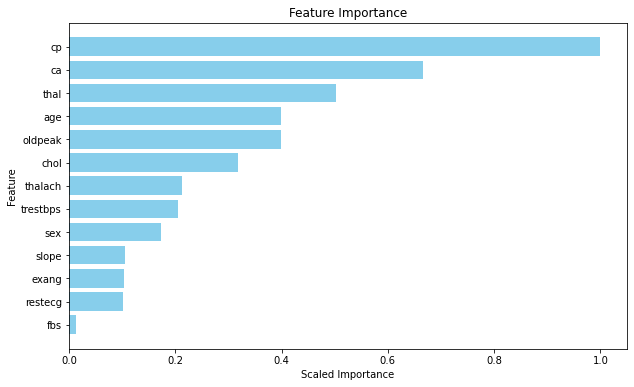

In [29]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['variable'], feature_importance['scaled_importance'], color='skyblue')
plt.xlabel('Scaled Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()